In [112]:
import pandas as pd
import numpy as np

# Resilience of university house prices
I always suspected that the impact of economic recessions in small university cities was smaller due to the sustained student rental market. But I didnt have a way to know until I decided to lear a bit of Data Science with Python :P

For this exercise I am going to need 3 pieces of information:
* Evolution of house prices in the US ("US-house-prices.csv")
* List of cities where university students represent a large percentage of the population ("uni-cities.txt")
* Evolution of GDP over time ("GDP.xls")

Observations:
* An economic recession starts with 2 quarters of GDP decline and ends wit 2 quarters of GDP growth
* The house price data I got only goes back to 1996 so I will focus on the last recession, ie the financial crisis circa 2008
* The house price data shows a monthly evolution but the GDP data is in quarters. I'll stick with quarters


In [113]:
# Dictionary to map state names to acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [114]:
def clean_university_list():
    '''I need to keep state names because there are cities with the same name in different states'''
    import re
    f = open('uni-cities.txt', 'r')
    universities = f.readlines()
    f.close
    StateCityPairs = []
    for line in universities:
        line = line.rstrip()
        # Lines ending in [edit] contain state names
        if re.search('\[edit\]$', line):
            State = re.sub(r'\[edit\]$', '', line)
        else:
            City = re.sub(r' \(.+$', '', line)
            #Append new pair to 'StateCityPairs'
            StateCityPairs.append([State,City])
    #Let's build the dataframe
    df = pd.DataFrame(StateCityPairs, columns=["State","RegionName"])
    return df

clean_university_list().head(10)


,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo
5,Alabama,Troy
6,Alabama,Tuscaloosa
7,Alabama,Tuskegee
8,Alaska,Fairbanks
9,Arizona,Flagstaff


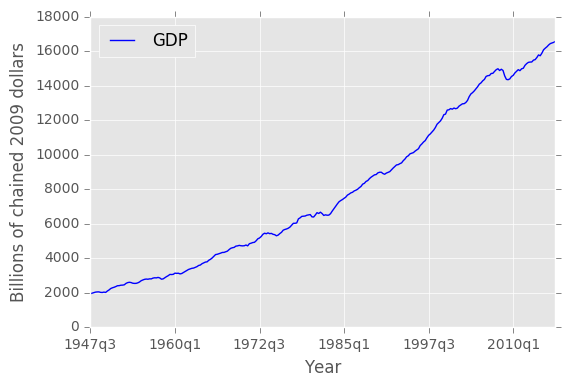

In [115]:
def get_GDP_data():
    global GDP
    GDP = pd.read_excel('GDP.xls', skiprows=9, names=['Year','GDP'], parse_cols="E,G")
    GDP = GDP.set_index('Year')
    
    return GDP

get_GDP_data().head(5)

import matplotlib.pyplot as plt
plt.figure()
GDP.plot(color='b').set_ylabel('Billions of chained 2009 dollars')
plt.show()


In [116]:
def get_recession_qtrs():

    get_GDP_data()
    GDP['%Change'] = GDP.pct_change()
    InRecession=False
    
    RecStartsList = []
    RecEndsList = []
    for q in range(len(GDP)):
        #print (GDP.iloc[q].name, GDP.iloc[q]['%Change'])
        if (q > 2) and (GDP.iloc[q-1]['%Change'] < 0) and (GDP.iloc[q-0]['%Change'] < 0) and (InRecession==False):
            #print (GDP.iloc[q].name, "Recession starts")
            InRecession=True
            RecStartsList.append(GDP.iloc[q].name)
        if (q > 2) and (GDP.iloc[q-1]['%Change'] > 0) and (GDP.iloc[q-0]['%Change'] > 0) and (InRecession==True):
            #print (GDP.iloc[q].name, "Recession ends")
            InRecession=False
            RecEndsList.append(GDP.iloc[q].name)
    
    RecessionDetails = pd.DataFrame()
    RecessionDetails['Start'] = RecStartsList
    RecessionDetails['End'] = RecEndsList
    print("Details of all recessions contained in the data")
    print (RecessionDetails)

    # Housing data goes back only to 1999 so we focus only the last recession
    started = RecessionDetails.iloc[len(RecessionDetails)-1]['Start']
    ended = RecessionDetails.iloc[len(RecessionDetails)-1]['End']
    return "Last recession started in " + started + " and ended in " + ended

get_recession_qtrs()

Details of all recessions contained in the data
    Start     End
0  1949q2  1950q2
1  1953q4  1954q3
2  1958q1  1958q3
3  1970q1  1970q3
4  1974q4  1975q3
5  1980q3  1981q1
6  1982q1  1983q1
7  1991q1  1991q3
8  2008q4  2009q4


'Last recession started in 2008q4 and ended in 2009q4'

In [117]:
def house_prices_to_quarters():

    df = pd.read_csv('US-house-prices.csv', usecols=[*range(1,3), *range(147,170)])
    # Might be interesting to see also how house prices evolved during the housing bubble: universities vs the rest
    etiqs = ['2008q1','2008q2','2008q3','2008q4','2009q1','2009q2','2009q3','2009q4','State','RegionName']

    alldata = []
    for i in range(1000):
    #for i in range(len(df)): #Uncomment this one to run on all data - it takes longer

        region = df.iloc[i,0]
        state = df.iloc[i,1]
        ts = df.iloc[i,2:]
        ts.index = pd.to_datetime(ts.index)
        ts = pd.to_numeric(ts)
        # House prices for a quarter will be the mean of the three months in that quarter
        ts = ts.resample('Q').mean()
        ts['State'] = states[state]
        ts['RegionName'] = region
        temp = list(ts.values)
        alldata.append(temp)
    answer = pd.DataFrame(alldata, columns=etiqs)
    answer = answer.set_index(['State','RegionName'])
    return answer

house_prices_to_quarters().head(8)



,,2008q1,2008q2,2008q3,2008q4,2009q1,2009q2,2009q3,2009q4
State,RegionName,,,,,,,,
New York,New York,508500.000000,503933.333333,499766.666667,487933.333333,477733.333333,465833.333333,455933.333333,456900.0
California,Los Angeles,535300.000000,502266.666667,469500.000000,443966.666667,426266.666667,413900.000000,406366.666667,403550.0
Illinois,Chicago,243733.333333,237900.000000,232000.000000,227033.333333,223766.666667,219700.000000,214100.000000,212100.0
Pennsylvania,Philadelphia,119566.666667,118133.333333,116933.333333,115866.666667,116200.000000,116166.666667,116733.333333,118100.0
Arizona,Phoenix,218633.333333,205266.666667,193766.666667,183333.333333,177566.666667,168233.333333,155933.333333,145750.0
Nevada,Las Vegas,250933.333333,232300.000000,213366.666667,194933.333333,181200.000000,164333.333333,146233.333333,137450.0
California,San Diego,461966.666667,441400.000000,424666.666667,407633.333333,395700.000000,389500.000000,391500.000000,397150.0
Texas,Dallas,119900.000000,115366.666667,112166.666667,109900.000000,107666.666667,105100.000000,104400.000000,103550.0


In [118]:
def get_results():

    df = house_prices_to_quarters()
    
    # The function above returned start of the recession = 2008q4 and end of the recession = 2009q4
    recession_qtrs = ['2008q4','2009q1','2009q2','2009q3','2009q4']
    df = df[recession_qtrs]
    #Looking for the lowest house prices in the whole recession period
    df['Min'] = df[recession_qtrs].min(axis=1)
    #Drop is measured from the beginning of the recession
    df['Drop'] = df['2008q4'] - df['Min']
    df['%Drop'] = df['Drop'] / df['2008q4']
    #print(df)
    unis = clean_university_list()
    unis = unis.set_index(['State','RegionName'])
    nouni = pd.merge(df, unis, how='left', left_index=True, right_index=True)
    uni =  pd.merge(df, unis, how='inner', left_index=True, right_index=True)
    #I create a temporary key so that I can get the difference between left and inner
    nouni['key'] = nouni.index
    uni['key'] = uni.index
    rest = nouni[~nouni.key.isin(uni.key)]

    print("Length of Unis dframe :  ", len(uni))
    print("Length of rest dframe :  ", len(rest))
    print("Mean % drop  in Unis  : ", '{:.1%}'.format(uni['%Drop'].mean()))
    print("Mean % drop elsewhere : ", '{:.1%}'.format(nouni['%Drop'].mean()))

    return

get_results()


Length of Unis dframe :   147
Length of rest dframe :   853
Mean % drop  in Unis  :  5.2%
Mean % drop elsewhere :  8.5%


# Conclusion
Based on the results, during the last recession prices of houses in cities with a significant student popoulation fell but less than in the rest of the country